# Balance Data Scenario

Klasifikasi hasil citra USG payudara (*breast cancer*) menggunakan arsitektur ResNet152v2 dengan jumlah yang sudah di resampling (*balance*), jumlah epoch sebanyak 30.

# Preparing the Data

### Import Library

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
base_dir = '/content/drive/MyDrive/Dataset/Balance Breast Cancer Dataset/data'

#Menentukan direktori data training
train_dir = os.path.join(base_dir, 'train')

train_benign = train_dir+'/benign'
train_malignant = train_dir+'/malignant'
train_normal = train_dir+'/normal'

#Menentukan direktori data testing
test_dir = os.path.join(base_dir, 'test')

test_benign = test_dir+'/benign'
test_malignant =test_dir+'/malignant'
test_normal = test_dir+'/normal'

#Menghitung total data train
print('total citra train:', len(os.listdir(train_benign))+
                            len(os.listdir(train_malignant))+
                            len(os.listdir(train_normal))
                            )
#Menghitung total data test
print('total citra test:', len(os.listdir(test_benign))+
                           len(os.listdir(test_malignant))+
                           len(os.listdir(test_normal)))

total citra train: 431
total citra test: 49


### Resize image

In [4]:
image_height = image_width = 224
batch_size = 16

In [5]:
data_train = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(image_height, image_width)
  )

Found 431 files belonging to 3 classes.


In [6]:
class_names = data_train.class_names
print(class_names)

['benign', 'malignant', 'normal']


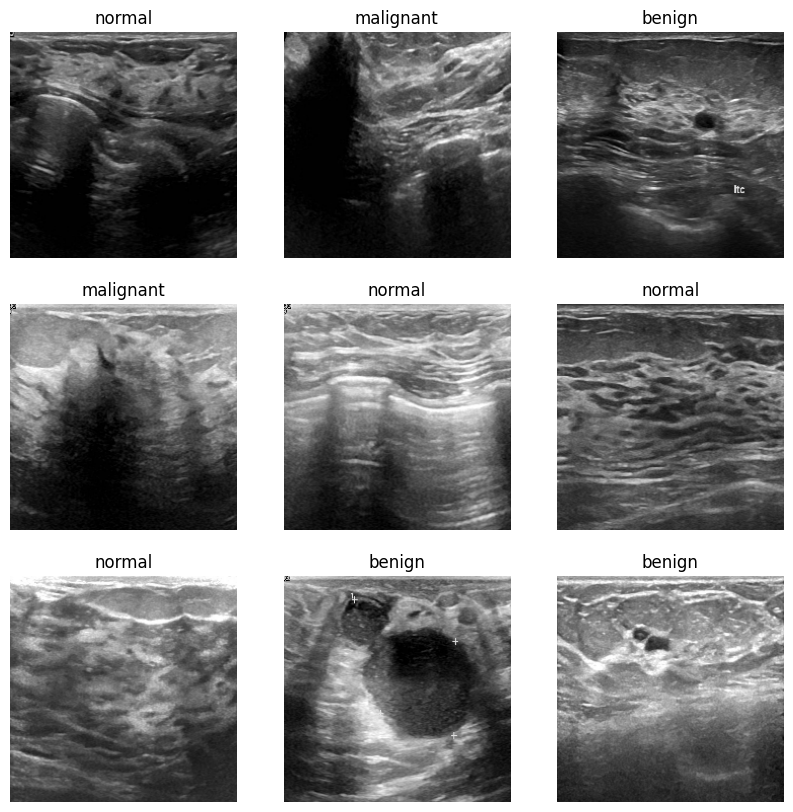

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in data_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
data_test = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  image_size=(image_height, image_width)
  )

Found 49 files belonging to 3 classes.


In [9]:
class_names = data_test.class_names
print(class_names)

['benign', 'malignant', 'normal']


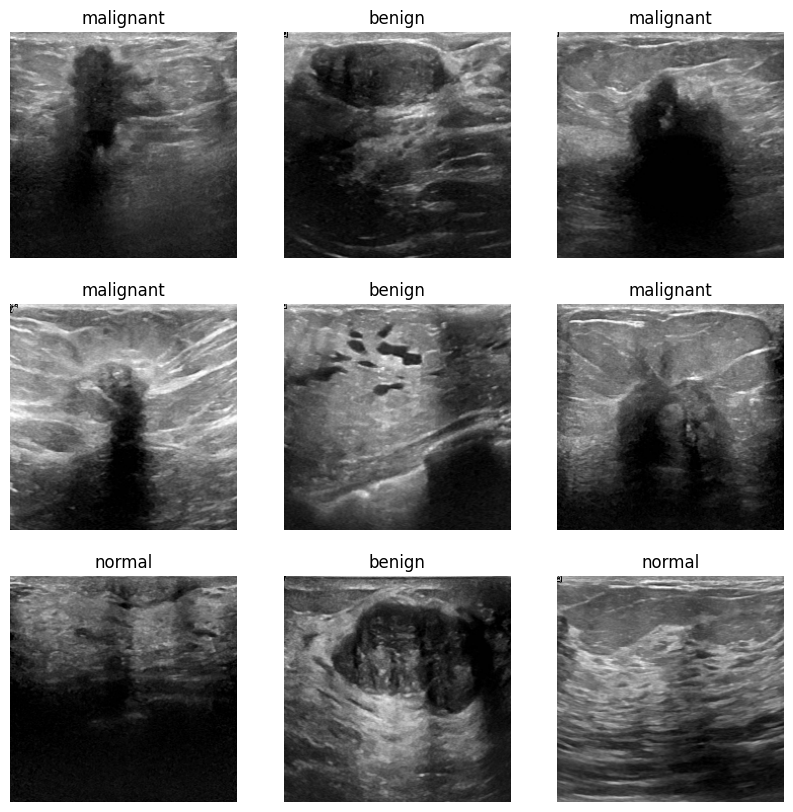

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in data_test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Augmentasi Data

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 10,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   brightness_range=[0.4,1.5],
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.15
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255,
                                        validation_split=0.15
                                        )
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    subset='training',
    seed = 123,
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    train_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    subset='validation',
    seed = 123,
    shuffle = False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_height,image_width),
    class_mode='categorical',
    batch_size= batch_size,
    seed = 123,
    shuffle = False
)

Found 368 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Found 49 images belonging to 3 classes.


In [13]:
from sklearn.utils import class_weight
import numpy as np
from sklearn.utils import compute_class_weight

train_classes = train_generator.classes
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(train_classes),
                                     y = train_classes
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.9583333333333334, 1: 0.8888888888888888, 2: 1.2026143790849673}

## Perancangan Arsitektur CNN

In [14]:
from keras import regularizers
tf.keras.backend.clear_session()

from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.regularizers import L2

model = tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(image_height, image_width, 3))),
    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
model.layers[0].trainable = False
model.summary()

234545216/234545216 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 512)         9437696   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 2, 2, 512)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               

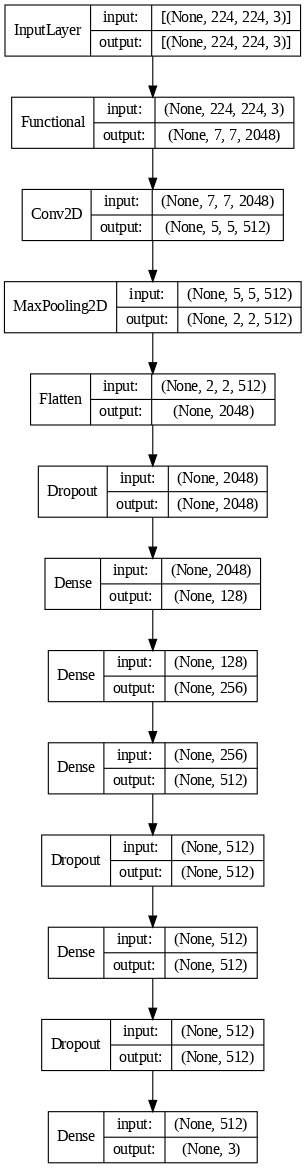

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False, dpi=80)

## Training Data

In [16]:
import keras

model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.SensitivityAtSpecificity(0.5)])

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.001)

In [18]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [19]:
%%time
history = model.fit(train_generator,
                    epochs=30,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=[reduce_lr, lr_scheduler],
                    shuffle = True)

Epoch 1/30
23/23 [==============================] - 50s 1s/step - loss: 3.4630 - accuracy: 0.3451 - specificity_at_sensitivity: 0.5625 - sensitivity_at_specificity: 0.5462 - val_loss: 2.1443 - val_accuracy: 0.4762 - val_specificity_at_sensitivity: 0.7381 - val_sensitivity_at_specificity: 0.8571 - lr: 0.0010
Epoch 2/30
23/23 [==============================] - 18s 773ms/step - loss: 2.3556 - accuracy: 0.4321 - specificity_at_sensitivity: 0.6712 - sensitivity_at_specificity: 0.6766 - val_loss: 1.7756 - val_accuracy: 0.7302 - val_specificity_at_sensitivity: 0.9921 - val_sensitivity_at_specificity: 0.9683 - lr: 0.0010
Epoch 3/30
23/23 [==============================] - 14s 554ms/step - loss: 2.0941 - accuracy: 0.5217 - specificity_at_sensitivity: 0.7799 - sensitivity_at_specificity: 0.7527 - val_loss: 1.7621 - val_accuracy: 0.6825 - val_specificity_at_sensitivity: 0.9683 - val_sensitivity_at_specificity: 0.9365 - lr: 0.0010
Epoch 4/30
23/23 [==============================] - 10s 451ms/step 

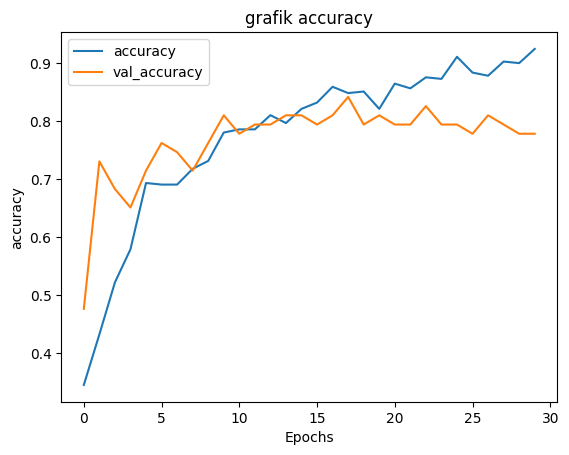

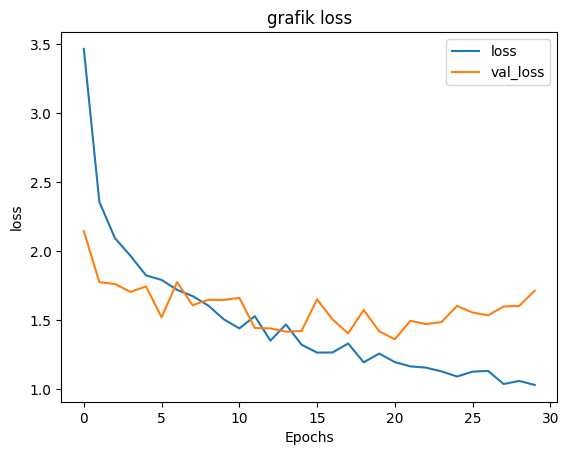

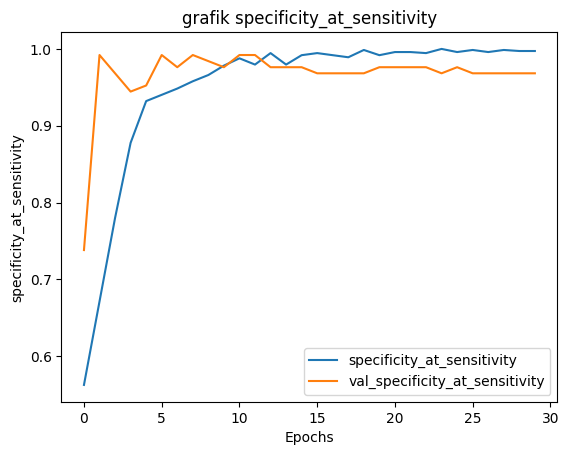

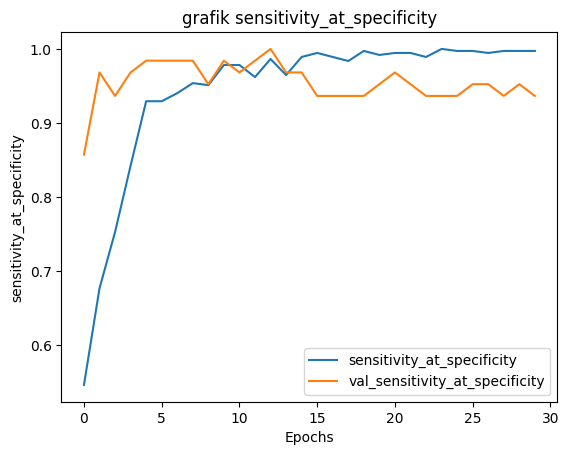

In [20]:
def grafik_plot(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.title('grafik '+string)
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

grafik_plot(history, "accuracy")
grafik_plot(history, "loss")
grafik_plot(history, "specificity_at_sensitivity")
grafik_plot(history, "sensitivity_at_specificity")

## Testing Data

In [21]:
true_labels = test_generator.classes
prob_test = model.predict(test_generator)
predictions = prob_test.argmax(axis=1)

print('Label Sebenarnya : ', true_labels)
print('Label Prediksi : ', predictions)

test_model = model.evaluate(test_generator, verbose=1)

4/4 [==============================] - 5s 519ms/step
Label Sebenarnya :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2]
Label Prediksi :  [0 0 0 0 0 2 0 0 0 0 1 0 0 0 2 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 2 2
 2 2 2 2 2 2 2 2 2 2 0 2]
4/4 [==============================] - 1s 159ms/step - loss: 1.2212 - accuracy: 0.8571 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000


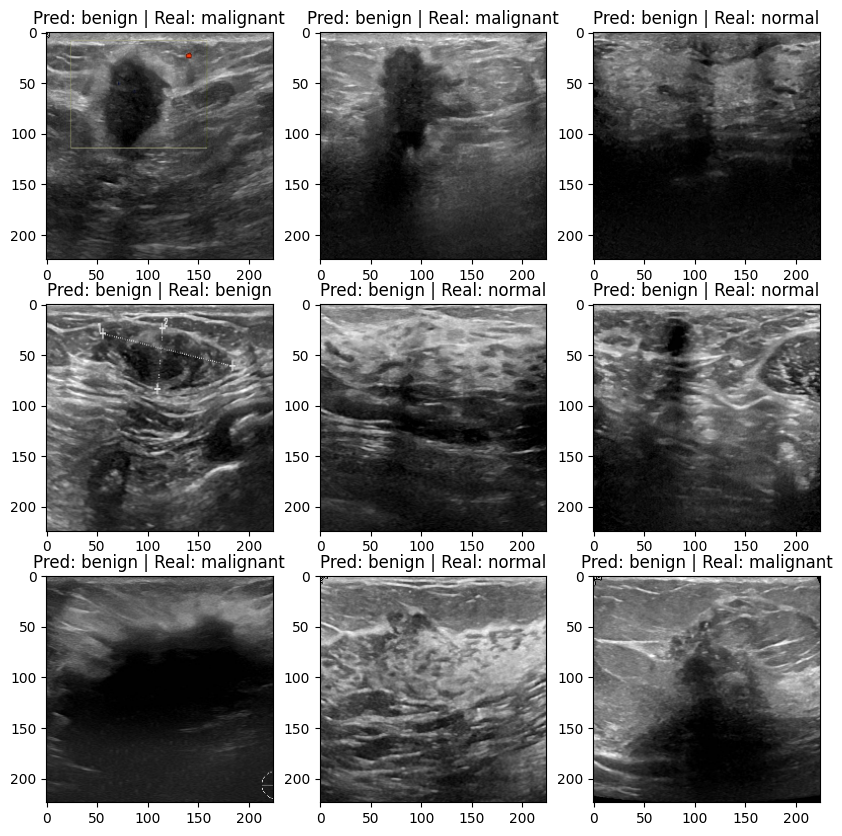

In [22]:
plt.figure(figsize=(10,10))
for images, labels in data_test.take(1):
  classifications = model(images)

  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    index = np.argmax(classifications[i])
    plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

In [23]:
print(train_generator.class_indices)

{'benign': 0, 'malignant': 1, 'normal': 2}


In [24]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1/225)
  im_input = tf.reshape(im_array, shape = [1, 224, 224, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  kelas = ['benign', 'malignant', 'normal']
  df['Kelas'] = kelas
  df = df[['Kelas', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_class = 'benign'
  elif predict_label == 1:
      predict_class = 'malignant'
  else:
      predict_class = 'normal'

  return predict_class, df

Saving malignant (1).png to malignant (1).png
1/1 [==============================] - 0s 34ms/step




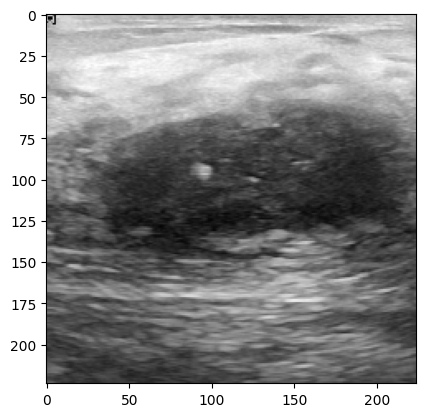


Citra dikenali sebagai malignant


       Kelas  Probability
0     benign     0.045417
1  malignant     0.949740
2     normal     0.004842




In [25]:
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nCitra dikenali sebagai " + label)
print('\n')
print(df)
print('\n')

## Evaluasi

In [26]:
loss, accuracy, specificity, sensitivity = model.evaluate(train_generator)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

23/23 [==============================] - 11s 449ms/step - loss: 0.9638 - accuracy: 0.9293 - specificity_at_sensitivity: 0.9986 - sensitivity_at_specificity: 1.0000
Loss train set:  0.9638368487358093
Akurasi train set:  0.929347813129425
Specificity train set:  0.998641312122345
Sensitivity train set:  1.0


In [27]:
val_loss, val_accuracy, val_specificity, val_sensitivity = model.evaluate(validation_generator)
print('Loss validation set: ', val_loss)
print('Akurasi validation set: ', val_accuracy)
print('Specificity validation set: ', val_specificity)
print('Sensitivity validation set: ', val_sensitivity)

4/4 [==============================] - 3s 596ms/step - loss: 1.7137 - accuracy: 0.7778 - specificity_at_sensitivity: 0.9683 - sensitivity_at_specificity: 0.9365
Loss validation set:  1.7136896848678589
Akurasi validation set:  0.7777777910232544
Specificity validation set:  0.9682539701461792
Sensitivity validation set:  0.9365079402923584


In [28]:
test_loss, test_accuracy, test_specificity, test_sensitivity = model.evaluate(test_generator)
print('Loss test set: ', test_loss)
print('Akurasi test set: ', test_accuracy)
print('Specificity test set: ', test_specificity)
print('Sensitivity test set: ', test_sensitivity)

4/4 [==============================] - 2s 387ms/step - loss: 1.2212 - accuracy: 0.8571 - specificity_at_sensitivity: 1.0000 - sensitivity_at_specificity: 1.0000
Loss test set:  1.2211806774139404
Akurasi test set:  0.8571428656578064
Specificity test set:  1.0
Sensitivity test set:  1.0


In [29]:
prediction= model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size), verbose=2)
prediction= (prediction > 0.5)
val_labels=test_generator.classes

4/4 - 1s - 1s/epoch - 275ms/step


In [30]:
import itertools
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  n_classes = cm.shape[0]

  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues)
  fig.colorbar(cax)

  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes),
         yticks=np.arange(n_classes),
         xticklabels=labels,
         yticklabels=labels)

  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  threshold = (cm.max() + cm.min()) / 2.

  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

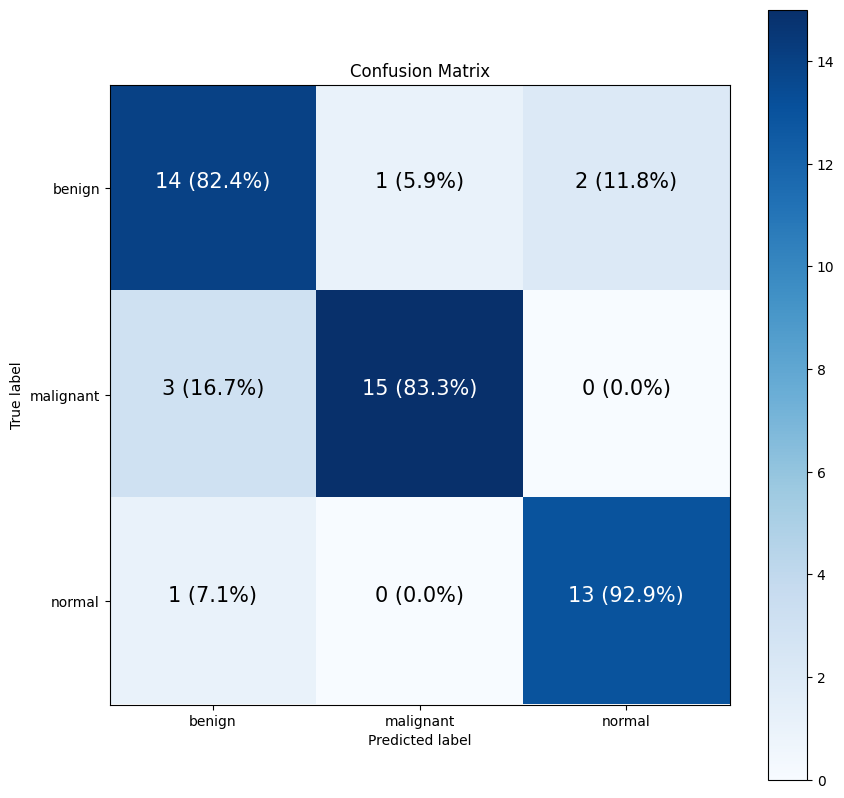

In [31]:
make_confusion_matrix(y_true=true_labels,
                      y_pred=predictions,
                      classes=test_generator.class_indices,
                      figsize=(10,10),
                      text_size=15)

In [37]:
from sklearn.metrics import classification_report

num_of_train_samples = 431
num_of_test_samples = 49
batch_size = 32

Y_pred = model.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Classification Report')
target_names = list(train_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

4/4 [==============================] - 1s 349ms/step
Classification Report
              precision    recall  f1-score   support

      benign       0.78      0.82      0.80        17
   malignant       0.94      0.83      0.88        18
      normal       0.87      0.93      0.90        14

    accuracy                           0.86        49
   macro avg       0.86      0.86      0.86        49
weighted avg       0.86      0.86      0.86        49



4/4 [==============================] - 1s 245ms/step


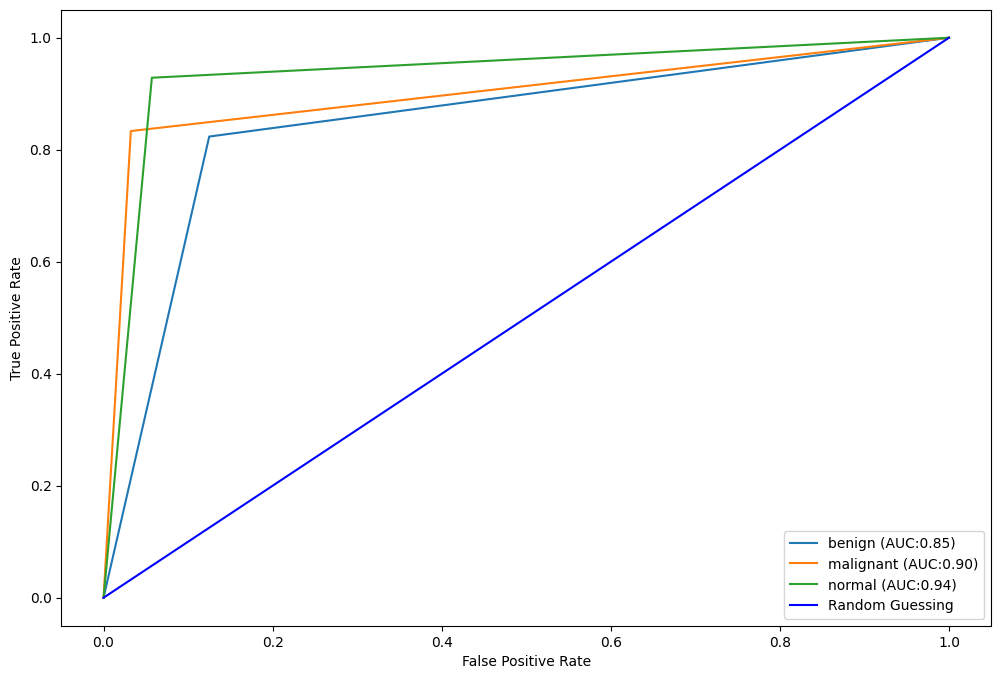

In [36]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

test_generator.reset()
y_pred = model.predict(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [34]:
model.save_weights('model_simple_weights_2.h5')
model.save('breast_cancer_balance.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
